# Merging Spatial Data Sets

Like regular pandas DataFrames, GeoDataFrames can be merged with one another based on common merging variables. *Unlike* regular DataFrames, however, GeoDataFrames can also be merged based on spatial relationships using *spatial joins* with `sjoin` and `sjoin_nearest`.

## Regular Merges

Regular merges (on attributes) work with dataframes in the familiar way, *except* that the syntax is just a little different. In particular, to merge a GeoDataFrame `gdf` with a DataFrame `df`, you would type `gdf.merge(df, on="key")` instead of the familiar `pd.merge(gdf, df)`. This helps ensure that geopandas knows that you want to keep `gdf` as a geodataframe.





## Spatial Join

The idea of a spatial join is that instead of joining rows across datasets based on common values of a variable, rows are joined based on spatial proximity. To illustrate, let's being with two datasets: the dataset of countries we've been playing with already, and a dataset of cities:

<Axes: >

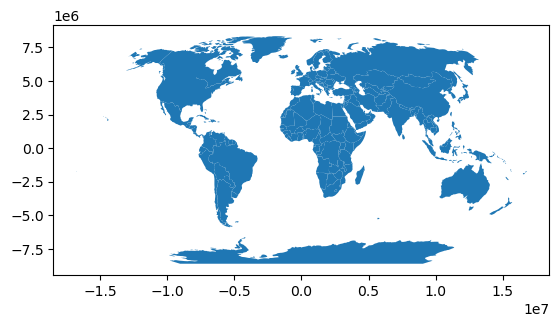

In [28]:
import geopandas as gpd

world = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/"
    "raw/refs/heads/main/notebooks/"
    "gis/example_data/world_countries/world_countries_robinson.geojson"
)

world.plot()

In [29]:
world.sample(3)

,featurecla,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,tlc,admin,...,fclass_tr,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,geometry
159,Admin-0 country,1,4,Antarctica,ATA,0,2,Indeterminate,1,Antarctica,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-2950733.383 -7955019.899, -29..."
34,Admin-0 country,1,5,Costa Rica,CRI,0,2,Sovereign country,1,Costa Rica,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-7765577.595 1023116.582, -7802508.3..."
5,Admin-0 country,1,3,Kazakhstan,KA1,1,1,Sovereignty,1,Kazakhstan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((7202132.129 5245560.427, 7171298.638..."


<Axes: >

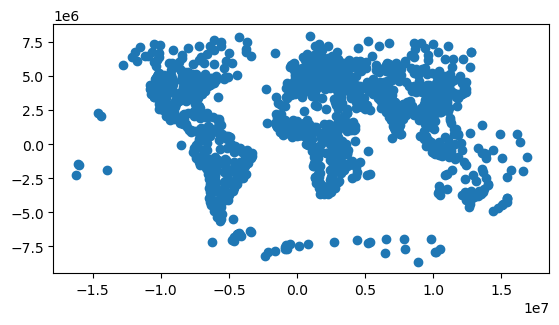

In [30]:
cities = gpd.read_file(
    "https://github.com/nickeubank/practicaldatascience_book/raw"
    "/refs/heads/main/notebooks/gis/example_data/world_cities/world_cities_robinson.geojson"
)

cities.plot()

In [31]:
cities.sample(5)

,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,nameascii,adm0cap,capin,...,fclass_id,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry
821,3,110,5,Admin-1 capital,Fez,None,Fes|F-s,Fez,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-447202.186 3642475.12)
1194,1,300,7,Admin-1 capital,Geneva,None,None,Geneva,0,None,...,None,None,None,None,None,None,None,None,None,POINT (516080.209 4932107.829)
298,4,50,5,Admin-1 capital,Oujda,None,None,Oujda,0,None,...,None,None,None,None,None,None,None,None,None,POINT (-170321.402 3710190.811)
723,4,50,8,Populated place,Manukau,None,Southern Auckland,Manukau,0,None,...,None,None,None,None,None,None,None,None,None,POINT (15444681.861 -3956875.686)
494,4,50,1,Populated place,Hailar,None,None,Hailar,0,None,...,None,None,None,None,None,None,None,None,None,POINT (9869316.008 5244003.816)


In this toy city dataset, you will notice that we have cities' names, but not the country in which they are located. Since we know this variable is in our `world` dataset, we can do a spatial join to match each city observation up with the country in which it is located:

In [32]:
cities_w_county = cities.sjoin(world, how="left", predicate="intersects")
cities_w_county.sample(3)

,scalerank_left,natscale,labelrank_left,featurecla_left,name_left,namepar,namealt,nameascii,adm0cap,capin,...,fclass_vn_right,fclass_tr_right,fclass_id_right,fclass_pl_right,fclass_gr_right,fclass_it_right,fclass_nl_right,fclass_se_right,fclass_bd_right,fclass_ua_right
368,4,50,2,Populated place,Torreón,None,Torreon,Torreon,0,None,...,None,None,None,None,None,None,None,None,None,None
383,4,50,2,Admin-1 capital,Ibadan,None,None,Ibadan,0,None,...,None,None,None,None,None,None,None,None,None,None
794,3,110,8,Admin-0 capital,Dushanbe,None,None,Dushanbe,1,None,...,None,None,None,None,None,None,None,None,None,None


Voilá! Just like that we've merged two datasets that have no variables in common. 

Note that like our regular merge/join methods, we can use `how` to dictate which observations remain in our joined dataset. Unlike a regular merge/join, though, we also have the argument `predicate` which dictates what spatial relationships should be merged. When merging points with polygons, there aren't a lot of ways you can imagine rows relating to one another. But spatial joins can also be done with lines and polygons (say, matching roads with the states they cross), or with polygons and polygons (matching media markets to states), and in those settings you can imagine more complicated relationships. For example, perhaps we only want to join roads to states if the road lies entirely within the state; or perhaps we want to join our roads to any state they touch. To accommodate these different relationships, `predicate` accepts:

- intersects
- contains
- within
- touches
- crosses
- overlaps



### Order of Join

Note that while normal merge/join are symmetric -- it doesn't really matter which is the right dataset and which is left -- order does matter for spatial joins, as only the *geometry* of one dataset is preserved. So if we do `cities.sjoin(world)`, the resulting geodataframe will be points (as above). But if we flip the order, we end up with country polygons:

<Axes: >

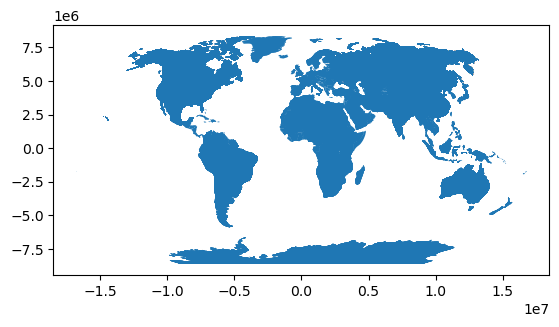

In [33]:
world.sjoin(cities).plot()

## Nearest Spatial Join

`sjoin` is terrific for linking observations that are in the same location. But sometimes we're interested not in joining records that are in exactly the same spot or are overlapping, but rather observations that are *near* to one another. 

For that, geopandas has `sjoin_nearest`. `sjoin_nearest`, as the name implies, merges an observation in one dataset to the *nearest* observation in another dataset. 

To illustrate, let's find out what city is closest to the "middle" of each country (e.g. closest to each country's centroid):

In [34]:
world["centroids"] = world.centroid
world = world.set_geometry("centroids")
center_most_city = world.sjoin_nearest(cities, how="inner")
center_most_city = center_most_city.rename(columns={"name_right": "centermost_city"})
center_most_city.sample(3)

,featurecla_left,scalerank_left,labelrank_left,sovereignt,sov_a3_left,adm0_dif,level,type,tlc,admin,...,fclass_tr_right,fclass_id_right,fclass_pl_right,fclass_gr_right,fclass_it_right,fclass_nl_right,fclass_se_right,fclass_bd_right,fclass_ua_right,fclass_tlc_right
21,Admin-0 country,1,3,Norway,NOR,0,2,Sovereign country,None,Norway,...,None,None,None,None,None,None,None,None,None,None
77,Admin-0 country,1,5,Lebanon,LBN,0,2,Sovereign country,1,Lebanon,...,None,None,None,None,None,None,None,None,None,None
157,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,1,Yemen,...,None,None,None,None,None,None,None,None,None,None


(Note we're getting those same errors about calculating distances using a "geographic CRS" we got before. Once again, geopandas is telling us something important, and I **definitely** wouldn't ignore these warnings in a real analysis. I just want to put off discussion of projections till a [future reading](gis_projections_and_crs.ipynb).)

Voilá! Obviously this isn't the *most* compelling illustrative example, but you could easily see how this might be helpful for, say, finding the supply depots closest to each store, the polling place closest to each voter, etc.

## Geometric Manipulations

As we saw above, geopandas has utilities (like `.centroid`) for manipulating the geometric objects. The [full like of supported manipulations can be found here](https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html), but some of the most useful are:

- generating centroids (`.centroid`), 
- calculating geometric properties like area or length (`.area` and `.length`), and 
- dissolving all the distinct geometries in a geodataframe into a single shape (`.unary_union`). 

Perhaps the most useful for relating data, though, is `.buffer()`. Buffer takes a set of points and converts them into circular polygons of a given radius. This is *extremely* useful if you, say, want to do a spatial join to find all the observations in another dataset that are within a given distance of your original points. 

To illustrate, suppose you wanted to find all the cities within 500 kilometers of each city in our `cities` dataset -- how would you do it?

Well, we can start by using `.buffer()` to create a new GeoDataFrame with circular polygons instead of points. Then we can do a spatial join of that new GeoDataFrame with our original cities GeoDataFrame to find all the cities that intersect each city's 500 km circle. 


And now we can do our buffer and join:

<Axes: >

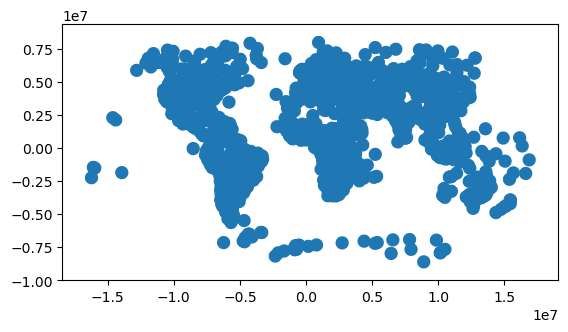

In [35]:
# Create circular polygons with buffer
cities["buffers"] = cities.buffer(500_000)

# Make the buffers the "official geometry"
city_buffers = cities.set_geometry("buffers")
city_buffers.plot()

I know that plot looks very similar to the one above, but that's just an illusion of the plots -- the plot we created before buffering turned our points into circles to help visualize them, but from the perspective of geopandas, they're just points with zero area. Now that we've buffered them, however, they're actually polygons with diameters of 500 kilometers:

In [36]:
city_buffers.sample(3)

,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,nameascii,adm0cap,capin,...,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry,buffers
1014,3,110,3,Admin-1 capital,Córdoba,None,None,Cordoba,0,None,...,None,None,None,None,None,None,None,None,POINT (-5794464.222 -3358121.98),"POLYGON ((-5294464.222 -3358121.98, -5296871.8..."
808,3,110,7,Admin-1 capital,Trondheim,None,None,Trondheim,0,None,...,None,None,None,None,None,None,None,None,POINT (759993.731 6666421.27),"POLYGON ((1259993.731 6666421.27, 1257586.094 ..."
364,4,50,2,Populated place,Okha,None,None,Okha,0,None,...,None,None,None,None,None,None,None,None,POINT (11409502.597 5693743.277),"POLYGON ((11909502.597 5693743.277, 11907094.9..."


With areas of $500,000^2 \pi = 7.84 * 10^{11}$ meters squared: 

In [37]:
city_buffers.sample(3).area

558    7.841371e+11
863    7.841371e+11
475    7.841371e+11
dtype: float64

So now we can do a spatial join of these circular polygons with our city points, and any cities that intersect with these buffers will be matched up, giving us a dataset of cities and their neighbors!

In [38]:
# Now join the polygons with our points
joined = cities.sjoin(city_buffers[["name", "buffers"]])
joined.sample(5)

,scalerank,natscale,labelrank,featurecla,name_left,namepar,namealt,nameascii,adm0cap,capin,...,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry,buffers,index_right,name_right
278,4,50,8,Admin-0 capital,Ljubljana,None,None,Ljubljana,1,None,...,None,None,None,None,None,None,POINT (1221166.524 4915887.993),"POLYGON ((1721166.524 4915887.993, 1718758.888...",1234,Rome
1119,2,200,1,Admin-1 capital,Bandung,None,None,Bandung,0,None,...,None,None,None,None,None,None,POINT (10137857.041 -743110.828),"POLYGON ((10637857.041 -743110.828, 10635449.4...",438,Malang
261,4,50,5,Admin-1 capital,Iquitos,None,None,Iquitos,0,None,...,None,None,None,None,None,None,POINT (-6914602.072 -401071.579),"POLYGON ((-6414602.072 -401071.579, -6417009.7...",968,Cruzeiro do Sul
533,4,50,3,Admin-1 region capital,Bordeaux,None,None,Bordeaux,0,None,...,None,None,None,None,None,None,POINT (-50589.332 4789505.008),"POLYGON ((449410.668 4789505.008, 447003.032 4...",38,Rouen
669,4,50,5,Admin-1 capital,Annaba,None,None,Annaba,0,None,...,None,None,None,None,None,None,POINT (685551.281 3948344.194),"POLYGON ((1185551.281 3948344.194, 1183143.645...",21,Cagliari


In [39]:
# Cleanup columns
joined = joined.rename(
    {"name_left": "city_name", "name_right": "nearby_city"}, axis="columns"
)
joined = joined.drop(["index_right", "buffers"], axis="columns")

# Cities are obviously within 500 kilometers of themselves, so
# drop the "self joins"
joined = joined[~(joined.city_name == joined.nearby_city)]

# Now check out a few!
joined.sort_values("city_name")

,scalerank,natscale,labelrank,featurecla,city_name,namepar,namealt,nameascii,adm0cap,capin,...,fclass_pl,fclass_gr,fclass_it,fclass_nl,fclass_se,fclass_bd,fclass_ua,fclass_tlc,geometry,nearby_city
346,4,50,2,Admin-1 capital,Abakan,None,None,Abakan,0,None,...,None,None,None,None,None,None,None,None,POINT (7291145.466 5706949.325),Novokuznetsk
346,4,50,2,Admin-1 capital,Abakan,None,None,Abakan,0,None,...,None,None,None,None,None,None,None,None,POINT (7291145.466 5706949.325),Kyzyl
346,4,50,2,Admin-1 capital,Abakan,None,None,Abakan,0,None,...,None,None,None,None,None,None,None,None,POINT (7291145.466 5706949.325),Krasnoyarsk
1165,2,200,8,Admin-0 capital,Abidjan,None,None,Abidjan,1,"De facto, admin",...,None,None,None,None,None,None,None,None,POINT (-379224.555 569318.534),Yamoussoukro
1165,2,200,8,Admin-0 capital,Abidjan,None,None,Abidjan,1,"De facto, admin",...,None,None,None,None,None,None,None,None,POINT (-379224.555 569318.534),Bouaké
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,1,300,2,Admin-1 region capital,Ōsaka,None,Osaka-Kobe,Osaka,0,None,...,None,None,None,None,None,None,None,None,POINT (12083472.403 3710306.48),Kyoto
1208,1,300,2,Admin-1 region capital,Ōsaka,None,Osaka-Kobe,Osaka,0,None,...,None,None,None,None,None,None,None,None,POINT (12083472.403 3710306.48),Hiroshima
1208,1,300,2,Admin-1 region capital,Ōsaka,None,Osaka-Kobe,Osaka,0,None,...,None,None,None,None,None,None,None,None,POINT (12083472.403 3710306.48),Matsuyama
1208,1,300,2,Admin-1 region capital,Ōsaka,None,Osaka-Kobe,Osaka,0,None,...,None,None,None,None,None,None,None,None,POINT (12083472.403 3710306.48),Miyazaki


And that's how we can compose operations to do some pretty amazing things!